Implementing an SVM and fitting it using quadratic programming via CVXOPT.

### Quadratic Programming (QP)

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.

Aim: Solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

In [4]:
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False # NOTE: turns off the printing of CVXOPT solution for the rest of the notebook

P = 2 * matrix([[1., 0.], [0., 4.]])

q = matrix([-8.,-16.])
G = matrix([[1.,1.,0.],[1.,0.,-1.]])
h = matrix([5.,3.,0.])

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Visualizing the solution

<ipython-input-5-c01e3a82d9c0>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2, F, cmap='jet')


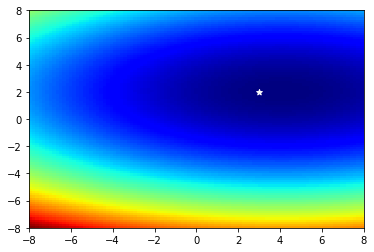

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

### Linear SVM

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

In [124]:
from sklearn.base import BaseEstimator
import sys

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)

        
        if Y.ndim == 1:
            Y = np.expand_dims(Y,axis=1)
    
        P = np.bmat([[np.ones((1,1)), np.zeros((1,102))], # 103x103
                    [np.zeros((1,1)), np.ones((1,1)), np.zeros((1, 101))],
                    [np.zeros((101, 103))]])
        P = matrix(P,P.shape)
        
        q = np.bmat([[np.zeros((3,1))],
                    [np.ones((100,1))*self.C]]) # 1x103
        q = matrix(q,q.shape)
        
        if X.shape[0] != Y.shape[0] and X.shape[1] == Y.shape[0]:
            Xt = X.T
        else:
            Xt = X
        if self.transform is not None:
            Y = Y.T
            col1 = (-Y*Xt).T
        else:
            col1 = -Y*Xt
        
        print(Y.shape)
#         print(X.shape)
        
        G = np.bmat([[col1, -Y, -1*np.identity(100)],
                    [np.zeros((100,3)), -1*np.identity(100)]])
        G = matrix(G,G.shape)
        
        h = np.bmat([[np.ones((100,1))*-1],
                     [np.zeros((100,1))]])
        h = matrix(h,h.shape)
    
            
        sol = solvers.qp(P, q, G, h)
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d+1:d+N+1]
        self.bias_ = ans[d:d+1]

        
        # A boolean array of length N having True for support
        # vectors and False for the rest.
        z = (X.dot(model.weights_) + self.bias_)
        if z.ndim == 1:
            z = np.expand_dims(z, 1)
        margin = np.squeeze(Y * z)
        compare = 1 - self.xi_

        self.support_vectors = np.isclose(margin,  1 - self.xi_)


        
    def predict_proba(self, X):

        if self.transform is not None:
            X = self.transform(X)
        
        if self.weights_.ndim == 1:
            self.weights_ = np.expand_dims(self.weights_,1)
            
        y_hat = X@self.weights_ + self.bias_ # Real-valued predictions for novel data

        
        
        return y_hat


    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

Let's see how our LinearSVM performs on some data.

In [125]:
from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

y = [2 * yy - 1 for yy in y]

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


<ipython-input-126-dd4d9779d49e>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
<ipython-input-126-dd4d9779d49e>:26: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')


(100, 1)


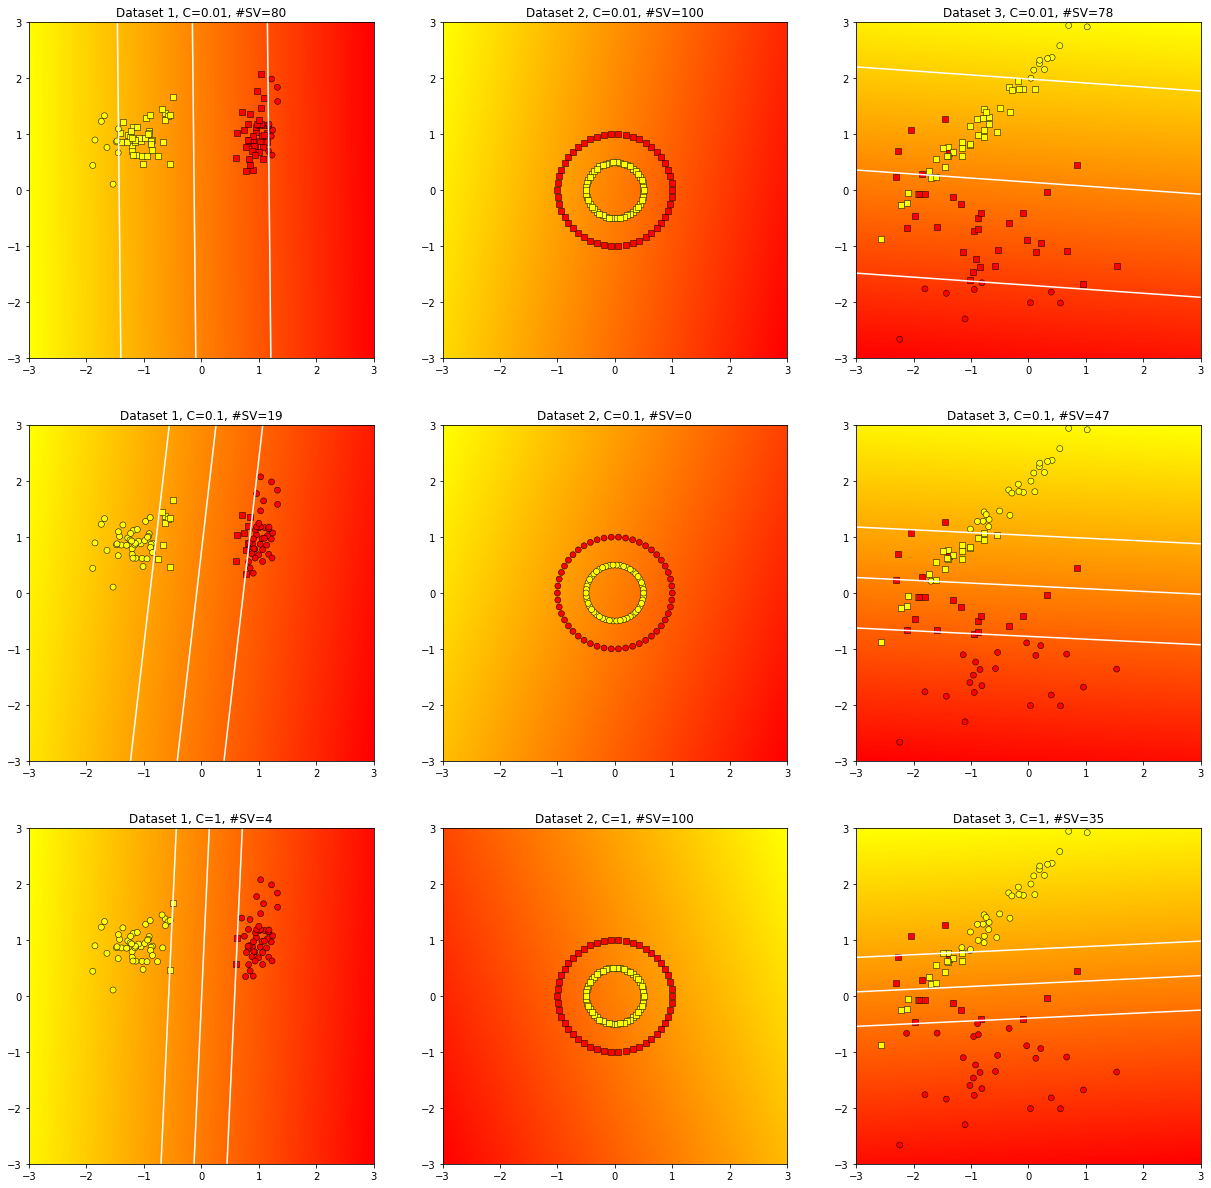

In [126]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        model = LinearSVM(C=C)
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Why does the number of support vectors decrease as $C$ increases?

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [127]:
model.weights_

array([[-0.0784521 ],
       [ 1.62264867]])

In [128]:
model.bias_

array([-0.35285101])

**Feature Transformation**

Separating data that is linearly inseparable by using feature transformation.

Implementing the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [122]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""

    A = np.array([[1,0,1,0,1],[0,1,0,1,0]])
    X = np.array(X)
    N = X.shape[0]
    print(N)

    Nx = np.bmat([[[X[:,0]],
                  [X[:,1]],
                  [np.square(X[:,0])],
                  [np.square(X[:,1])],
                  [X[:,0]*X[:,1]]]])
    Nx = Nx.reshape(N,5)

    return Nx
    
z = append_second_order([[1,2],[2,3]])

2


100
(1, 5)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 100 and the array at index 1 has size 1

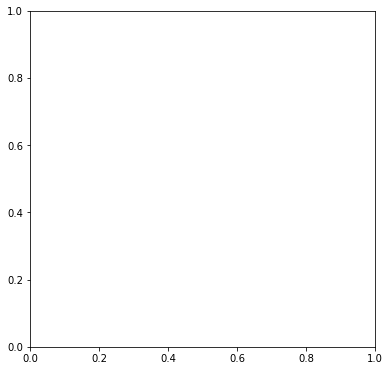

In [123]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        model = LinearSVM(C=C, transform=append_second_order)
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()